In [115]:
import pickle# load the model from disk
import numpy as np
import pandas as pd
import cv2 as cv
from collections import Counter

from matplotlib.image import imread
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join

import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras

# generación del set de test
batch_size = 32   # tamaño de los conjuntos de entrenamiento que se le pasan al modelo para que no aprenda todo de golpe y no se bloquee.
img_height = 144
img_width = 144
flag_first_exec = 0
if flag_first_exec == 0:
    flag_first_exec = 1

### CARGA DE LOS MODELOS SOLO EN LA PRIMERA EJECUCIÓN ####
if flag_first_exec == 0:
    # MODELO OPCIÓN 0 ###
    model_vgg16_signs0 = keras.models.load_model('./models/model_vgg16_signs0.h5')

    # MODELO OPCIÓN 1 ###
    model_vgg16_class1 = keras.models.load_model('./models/model_vgg16_class1.h5')
    model_vgg16_signs1 = keras.models.load_model('./models/model_vgg16_signs1.h5')

    # MODELO OPCIÓN 2 ###
    model_vgg16_class2 = keras.models.load_model('./models/model_vgg16_class2.h5')
    model_vgg16_signs2 = keras.models.load_model('./models/model_vgg16_signs2.h5')

# Generación del conjunto de X_test
df_dict = []
data_path = os.getcwd() + os.sep + 'data_speed' 
only_image_names = [f for f in listdir(data_path) if isfile(join(data_path, f))]

# cargar imágenes con 32 bits
for image_name in only_image_names:
    if ".png" in image_name:           # se reduce el set de set (este notebook solo sirve para comprobar que el modelo se carga)   
        image_fullpath = data_path + os.sep + image_name
        image_cv = cv.imread(image_fullpath)     # con el 0 se lee en blanco y negro, sin nada, se lee en color

        # las imagenes originales tienen tamañanos distintos  -> con esta función se ponen en el tamaño común para todas (y será el tamaño de entrada al modelo)
        image_cv = cv.resize(image_cv, (img_height, img_width)) 
        df_dict.append({'image':image_cv})

df = pd.DataFrame(df_dict)
X_test_32 = np.stack(np.array(df["image"]))
X_test_32_1 = X_test_32     #/255
X_test_32_1.shape

(21, 144, 144, 3)

In [112]:
### PREDICCIONES ####
# Variables de predicción de señal (tanto final como cada modelo)
Y_pred = []         # predicción final 
Y_pred_mod0 = []    # predicción modelo 0
Y_pred_mod1 = []    # predicción modelo 1
Y_pred_mod2 = []    # predicción modelo 2


for i in range(len(X_test_32_1)):
    # imagen a analizar
    img_analisis = X_test_32_1[i].reshape(1,144,144,3)

    ### PREDICCIONES MODELO 0 ###
    pred_mod0 = np.argmax(model_vgg16_signs0.predict(img_analisis))
    Y_pred_mod0.append(pred_mod0)

    ### PREDICCIONES MODELO 1 ###
    predictions_vgg16_class1 = model_vgg16_class1.predict(img_analisis)
    if np.argmax(predictions_vgg16_class1) == 2:
        predictions_vgg16_signs1 = model_vgg16_signs1.predict(img_analisis)

        # se añade 1 a la clase de la señal ya que este submodelo no tiene en cuenta la clase 'no_speed'
        pred_mod1 = np.argmax(predictions_vgg16_signs1)+1
        Y_pred_mod1.append(pred_mod1)      
    else:
        Y_pred_mod1.append(0)
    
    ### PREDICCIONES MODELO 2 ###
    predictions_vgg16_class2 = model_vgg16_class2.predict(img_analisis)
    if np.argmax(predictions_vgg16_class2) == 2:
        predictions_vgg16_signs2 = model_vgg16_signs2.predict(img_analisis)
        pred_mod2 = np.argmax(predictions_vgg16_signs2)
        Y_pred_mod2.append(pred_mod2)
    else:
        Y_pred_mod2.append(0)

    ### PREDICCIÓN CONJUNTA ######
    Y_pred.append([pred_mod0, pred_mod1, pred_mod2])

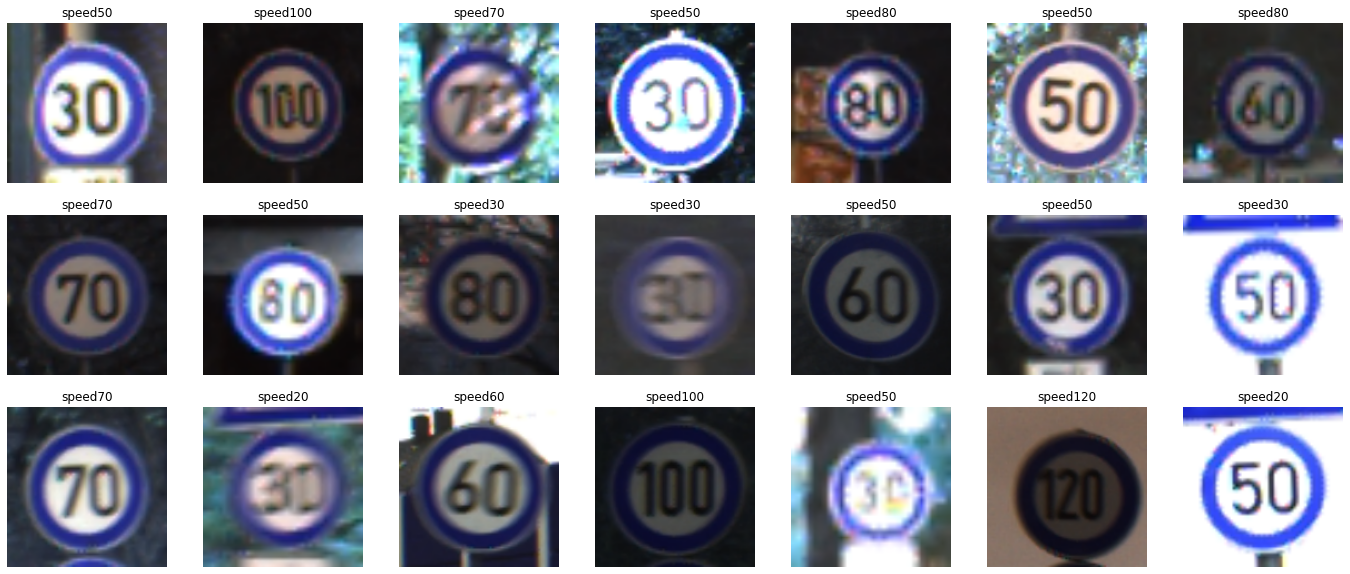

In [102]:
class_names_op2 = ['no_target', 'others', 'target']
class_names_op1 = ['no_speed', 'others', 'speed']
signs_names = ['no_speed', 'speed100', 'speed120', 'speed20', 'speed30', 'speed50', 'speed60', 'speed70', 'speed80']

plt.figure(figsize=(24, 10))
for i in range(21):
    ax = plt.subplot(3, 7, i + 1)
    plt.imshow(X_test_32_1[i])
    plt.title(signs_names[Y_pred_mod0[i]])
    plt.axis("off")

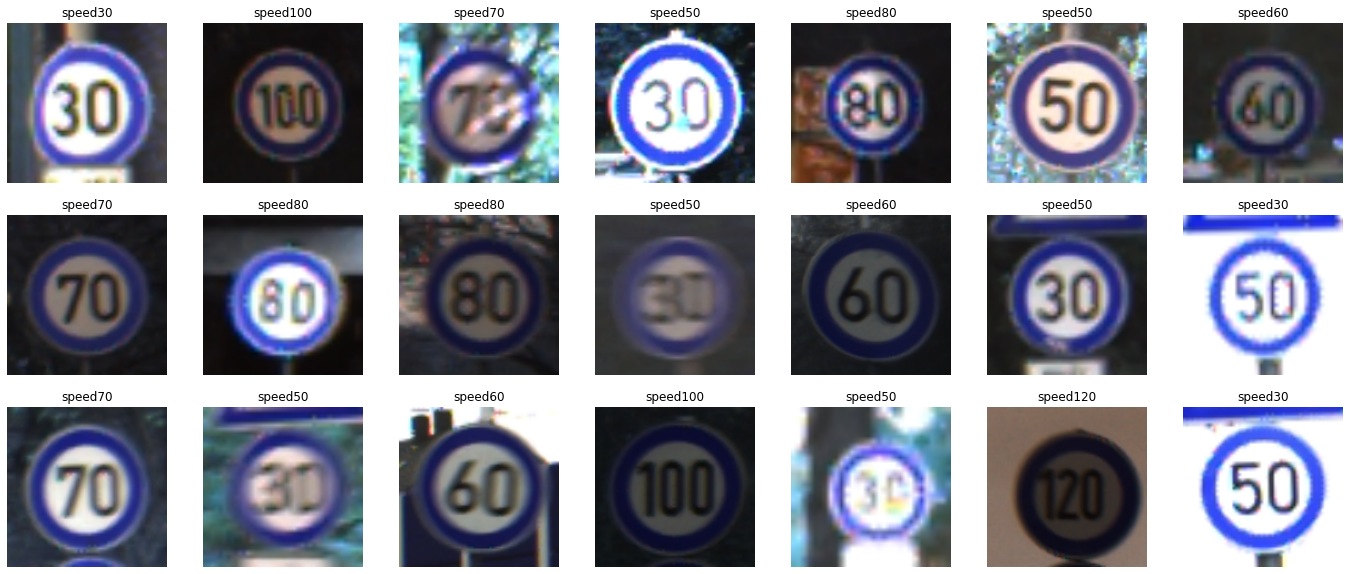

In [103]:
plt.figure(figsize=(24, 10))
for i in range(21):
    ax = plt.subplot(3, 7, i + 1)
    plt.imshow(X_test_32_1[i])
    plt.title(signs_names[Y_pred_mod1[i]])
    plt.axis("off")

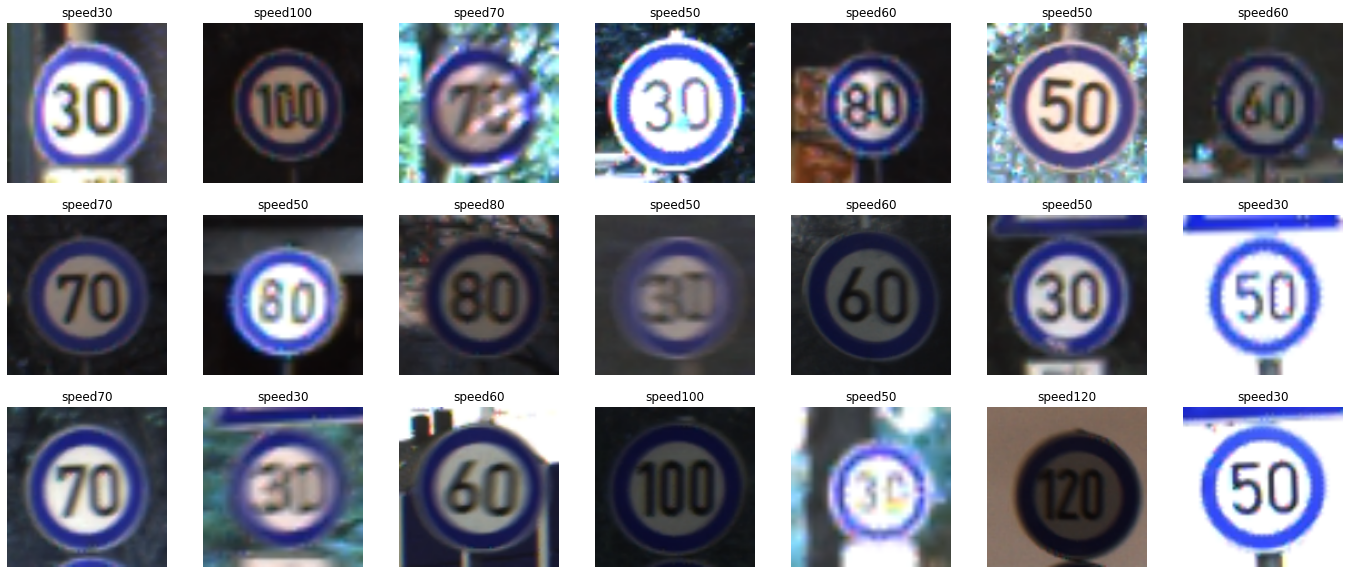

In [104]:
plt.figure(figsize=(24, 10))
for i in range(21):
    ax = plt.subplot(3, 7, i + 1)
    plt.imshow(X_test_32_1[i])
    plt.title(signs_names[Y_pred_mod2[i]])
    plt.axis("off")

In [136]:
def most_frequent(List):
    if List[0] != List [1] and List[0] != List[2] and List[1] != List[2]:
        return List[1]
    else:
        occurence_count = Counter(List)
        return occurence_count.most_common(1)[0][0]

for check in range(21):
    print(Y_pred_mod0[check],Y_pred_mod1[check],Y_pred_mod2[check],most_frequent(Y_pred[check]))   

5 4 4 4
1 1 1 1
7 7 7 7
5 5 5 5
8 8 6 8
5 5 5 5
8 6 6 6
7 7 7 7
5 8 5 5
4 8 8 8
4 5 5 5
5 6 6 6
5 5 5 5
4 4 4 4
7 7 7 7
3 5 4 4
6 6 6 6
1 1 1 1
5 5 5 5
2 2 2 2
3 4 4 4


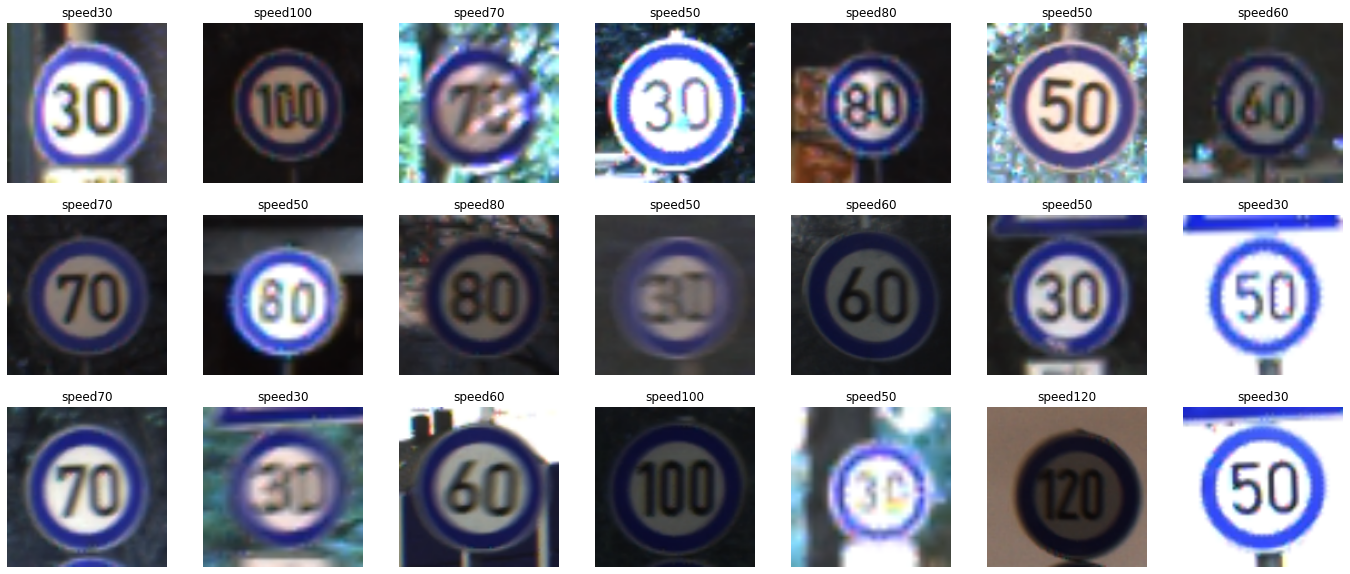

In [137]:
plt.figure(figsize=(24, 10))
for i in range(21):
    ax = plt.subplot(3, 7, i + 1)
    plt.imshow(X_test_32_1[i])
    plt.title(signs_names[most_frequent(Y_pred[i])])
    plt.axis("off")